In [1]:
import tensorflow as tf
from tf_agents.agents import ddpg
from tf_agents.agents.ddpg import ddpg_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import tf_py_environment, py_environment, batched_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.utils import common
from tf_agents.specs import array_spec
from tf_agents.trajectories import time_step as ts

import matplotlib.pyplot as plt
import numpy as np
import wandb

import sys
sys.path.insert(0, '..')
import utils.dataloader as dataloader
import utils.actorNetworkCustom as actornet
import utils.criticNetworkCustom as criticnet
import utils.modelgenerator as MG

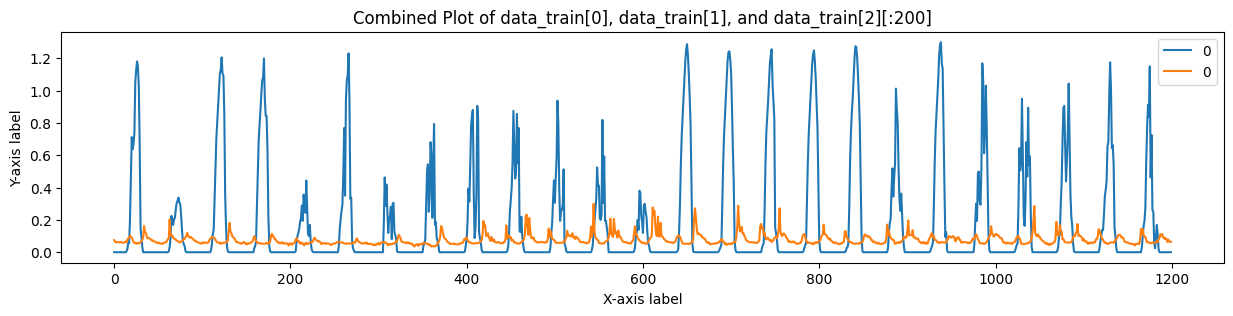

In [2]:
# Load data
customer = 1

data_train = dataloader.get_customer_data(dataloader.loadData('../../data/load1011.csv'),
                                          dataloader.loadPrice('../../data/price_wo_outlier.csv'), 
                                          dataloader.loadMix("../../data/fuel2021.csv"), customer)
data_eval = dataloader.get_customer_data(dataloader.loadData('../../data/load1112.csv'),
                                         dataloader.loadPrice('../../data/price_wo_outlier.csv'), 
                                         dataloader.loadMix("../../data/fuel2122.csv"), customer)
data_test = dataloader.get_customer_data(dataloader.loadData('../../data/load1213.csv'),
                                         dataloader.loadPrice('../../data/price_wo_outlier.csv'), 
                                         dataloader.loadMix("../../data/fuel2223.csv"), customer)

fig, ax = plt.subplots(figsize=(15,3)) 
# Assuming data_train is a list or array-like object
#data_train[0][:200].plot(label='Load', ax=ax)
data_train[1][:1200].plot(label='PV', ax=ax)
data_train[2][:1200].plot(label='Price', ax=ax)

# Add labels, title, and legend
plt.xlabel('X-axis label')
plt.ylabel('Y-axis label')
plt.title('Combined Plot of data_train[0], data_train[1], and data_train[2][:200]')
plt.legend()

# Show the plot
plt.show()

In [3]:
# Action clipping weg
# Reset überarbeiten

import numpy as np
import tensorflow as tf
from tf_agents.environments import py_environment
from tf_agents.specs import array_spec
from tf_agents.trajectories import time_step as ts
import wandb


class Battery(py_environment.PyEnvironment):

    def __init__(self, load_data, pv_data, price_data):
 
        #Time steps
        self._current_timestep = -1
        self._max_timesteps = (48 * 365)-1 #Timeslots: 2*24*365, starting at 0 -> -1

        #Battery parameters
        self._capacity = 13.5
        self._power_battery = 4.6/2
        self._init_charge = 0.0
        self._soe = 0.0
        self._power_grid = 25.0
        self._feed_in_tarif = 0.076
        self._total_electricity_bill = 0.0
        self._efficiency = 0.95

        #Observation and Action space
        self._action_spec = array_spec.BoundedArraySpec(shape=(1,), dtype=np.float32, minimum=-self._power_battery, maximum=self._power_battery, name='action')
        self._observation_spec = array_spec.BoundedArraySpec(shape=(6,), dtype=np.float32, name='observation')

        #Data
        self._load_data = load_data
        self._pv_data = pv_data
        self._electricity_prices = price_data

        #Reset
        self._episode_ended = False

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def _reset(self):
        self._current_timestep = -1 #is set to -1, indicating that the next timeslot will be the first one.
        self._soe = self._init_charge #is set to the initial charge value (_init_charge).
        self._total_electricity_bill = 0.0 #as it accumulates the electricity cost during each episode.
       
        observation = np.array([
            self._soe, 
            self._load_data.iloc[0,0], 
            self._pv_data.iloc[0,0], 
            self._electricity_prices.iloc[0,0], 
            self._electricity_prices.iloc[1:5,0].mean(), # Price Prediction: 2 hour mean
            self._pv_data.iloc[1:5,0].mean()], # PV Prediction: 4 hour mean
            dtype=np.float32)
        self._episode_ended = False
        
        return ts.restart(observation)


    def _step(self, action):
        
        #0. Set time
        self._current_timestep += 1
        #Check for Episode termination to reset
        if self._episode_ended:
            return self.reset()

        # 1. Balance Battery -> Action clipping unnötig
        soe_old = self._soe
        self._soe = np.clip(soe_old + action[0], 0.0, self._capacity, dtype=np.float32)
        penalty_soe  = np.abs(action[0] - (self._soe - soe_old))*5
        
        lower_threshold, upper_threshold = 0.10 * self._capacity, 0.90 * self._capacity
        if self._soe < lower_threshold:
            penalty_aging = np.abs(lower_threshold - self._soe) * 5
        elif self._soe > upper_threshold:
            penalty_aging = np.abs(self._soe - upper_threshold) * 5
        else:
            penalty_aging = 0 

        p_battery = soe_old - self._soe #Clipped to actual charging. + -> discharging/ providing energy
        
        #2. Get data
        price_buy = self._electricity_prices.iloc[self._current_timestep, 0]
        p_load = self._load_data.iloc[self._current_timestep, 0] 
        p_pv = self._pv_data.iloc[self._current_timestep, 0] 
        #2.1 Get forecasts
        price_forecast_1 = self._electricity_prices.iloc[self._current_timestep+1 : self._current_timestep+5, 0].mean() # Mean of next 2 hours
        p_pv_forecast_1 = self._pv_data.iloc[self._current_timestep+1 : self._current_timestep+5, 0].mean() # Mean of next 2 hours
        
        #3. Balance Grid
        if price_buy >= self._feed_in_tarif: # Hoher Kaufpreis, daher Eigennutzung
            grid = p_load - p_pv - p_battery
            grid_buy = grid if grid > 0 else 0
            grid_sell = abs(grid) if grid < 0 else 0
        elif price_buy < self._feed_in_tarif: # Hoher Verkaufspreis, daher alles verkaufen
            grid_buy = p_load
            grid_sell = p_pv + p_battery

        #4. Calculate profit
        profit = (grid_sell*self._feed_in_tarif) - (grid_buy*price_buy)
        self._total_electricity_bill += profit

        #5. Calculate reward
        reward = profit - penalty_soe - penalty_aging
        
        #6. Create observation
        observation = np.array([self._soe, p_load, p_pv, price_buy, price_forecast_1, p_pv_forecast_1], dtype=np.float32)
        
        if self._current_timestep % 100 == 0:
            #Logging
            wandb.log({
                'Action [2.3, -2.3]': action[0], 
                'SoE [0, 13.5]': self._soe, 
                'Imbalance': penalty_soe ,
                'Profit (+ profit, - cost)': profit,
                'Total Profit': self._total_electricity_bill,
                'Current Timestep' : self._current_timestep,
                'Reward' : reward,
                })
        # Check for episode end
        if self._current_timestep >= self._max_timesteps-8: 
            #wandb.log({'Profit': self._total_electricity_bill})
            self._episode_ended = True
            return ts.termination(observation=observation,reward=reward)          
        else:
            return ts.transition(observation=observation,reward=reward)

In [4]:
batch_size = 64

# Assuming Battery is your custom environment
# Define your environment creation function
def create_battery_env(load_data, pv_data, price_data):
    return Battery(load_data=load_data, pv_data=pv_data, price_data=price_data)

# Training environment setup
py_envs_train = [create_battery_env(data_train[0], data_train[1], data_train[2]) for _ in range(batch_size)]
batched_env_train = batched_py_environment.BatchedPyEnvironment(envs=py_envs_train)
tf_env_train = tf_py_environment.TFPyEnvironment(batched_env_train)

# Evaluation environment setup
py_envs_eval = [create_battery_env(data_eval[0], data_eval[1], data_eval[2]) for _ in range(batch_size)]
batched_env_eval = batched_py_environment.BatchedPyEnvironment(envs=py_envs_eval)
tf_env_eval = tf_py_environment.TFPyEnvironment(batched_env_eval)

# Testing environment setup
py_envs_test = [create_battery_env(data_test[0], data_test[1], data_test[2]) for _ in range(batch_size)]
batched_env_test = batched_py_environment.BatchedPyEnvironment(envs=py_envs_test)
tf_env_test = tf_py_environment.TFPyEnvironment(batched_env_test)

# Print
print("Batch size: ", tf_env_train.batch_size)
num_states = tf_env_train.observation_spec().shape[0]
print("Size of State Space ->  {}".format(num_states)) #SoE, price, price forecast 1-6
num_actions = tf_env_train.action_spec().shape[0]
print("Size of Action Space ->  {}".format(num_actions))
upper_bound = tf_env_train.action_spec().maximum.item()
lower_bound = tf_env_train.action_spec().minimum.item()
print("Max Value of Action ->  {}".format(upper_bound))

Batch size:  64
Size of State Space ->  6
Size of Action Space ->  1
Max Value of Action ->  2.299999952316284


In [5]:
m1 = MG.ModelGenerator()
# get_dense_layers(), get_bilstm_model(), get_lstm_model(), get_cnn_lstm_model(), get_cnn_model()
custom_layers = m1.get_dense_layers(layers=3, units=128)

# Create a copy of the layers, so no weights are duplicated
def copy_layer(layer):
    return tf.keras.layers.deserialize({'class_name': layer.__class__.__name__, 'config': layer.get_config()})

# Create copies of the original layers
actor_layers = [copy_layer(layer) for layer in custom_layers]
target_actor_layers = [copy_layer(layer) for layer in custom_layers]
critic_layers = [copy_layer(layer) for layer in custom_layers]
target_critic_layers = [copy_layer(layer) for layer in custom_layers]

In [6]:
# global step to improve TF built in functionality (weight decay, learning rate, etc.), distributed training, resuming training
global_step = tf.compat.v1.train.get_or_create_global_step()
actor_learning_rate = 1e-3 #-2 bis -4
critic_learning_rate = 1e-2 #-1 bis -3
ou_stddev = 0.3 # 0.2 , 0.3
ou_damping = 0.15 #0.15
target_update_tau = 0.05 # 0.005, 0.01, 0.05
target_update_period = 10 # 5, 20, 50
dqda_clipping = 1
gamma = 0.9 # 0.9, 0.99
reward_scale_factor = 1 # 1.0
gradient_clipping = None

actor_net = actornet.ActorNetwork(
    observation_spec=tf_env_train.observation_spec(),
    action_spec=tf_env_train.action_spec(),
    custom_layers=[actor_layers],
    )

critic_net = criticnet.CriticNetwork(
    observation_spec=tf_env_train.observation_spec(),
    action_spec=tf_env_train.action_spec(),
    custom_layers=[critic_layers],
    )

target_actor_network = actornet.ActorNetwork(
    observation_spec=tf_env_train.observation_spec(),
    action_spec=tf_env_train.action_spec(),
    custom_layers=[target_actor_layers],
    )

target_critic_network = criticnet.CriticNetwork(
    observation_spec=tf_env_train.observation_spec(),
    action_spec=tf_env_train.action_spec(),
    custom_layers=[target_critic_layers],
    )

tf_agent = ddpg_agent.DdpgAgent(
    tf_env_train.time_step_spec(),
    tf_env_train.action_spec(),
    actor_network=actor_net,
    critic_network=critic_net,
    actor_optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=actor_learning_rate),
    critic_optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=critic_learning_rate),
    ou_stddev=ou_stddev,
    ou_damping=ou_damping,
    target_actor_network=target_actor_network,
    target_critic_network=target_critic_network,
    target_update_tau=target_update_tau,
    target_update_period=target_update_period,
    dqda_clipping=dqda_clipping,
    td_errors_loss_fn=tf.compat.v1.losses.huber_loss,
    gamma=gamma,
    reward_scale_factor=reward_scale_factor,
    gradient_clipping=gradient_clipping,
    debug_summaries=False,
    summarize_grads_and_vars=False,
    train_step_counter=global_step,
)

tf_agent.initialize()

eval_policy = tf_agent.policy
collect_policy = tf_agent.collect_policy

In [7]:
replay_buffer_capacity = 1000000
initial_collect_steps = 1000
collect_steps_per_iteration = 2000

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=tf_env_train.batch_size,
    max_length=replay_buffer_capacity,
)

initial_collect_driver = dynamic_step_driver.DynamicStepDriver(
    tf_env_train,
    collect_policy,
    observers=[replay_buffer.add_batch],
    num_steps=initial_collect_steps,
)

collect_driver = dynamic_step_driver.DynamicStepDriver(
    tf_env_train,
    collect_policy,
    observers=[replay_buffer.add_batch],
    num_steps=collect_steps_per_iteration,
)

In [8]:
# Param for iteration
num_iterations = 5000

wandb.login()
wandb.init(
    project="DDPG_battery_testing",
    job_type="train_eval_test",
    name="Horizon_3h_explore",
    config={
        "train_steps": num_iterations,
        "batch_size": batch_size,
        "actor_learning_rate": actor_learning_rate,
        "critic_learning_rate": critic_learning_rate}
)
artifact = wandb.Artifact(name='save', type="checkpoint")

eval_metrics = [tf_metrics.AverageReturnMetric(batch_size=batch_size)]
test_metrics = [tf_metrics.AverageReturnMetric(batch_size=batch_size)]

"""train_checkpointer = common.Checkpointer(
    ckpt_dir='checkpoints/ddpg/',
    max_to_keep=1,
    agent=tf_agent,
    policy=tf_agent.policy,
    replay_buffer=replay_buffer,
    global_step=global_step
)
train_checkpointer.initialize_or_restore()"""

global_step = tf.compat.v1.train.get_global_step()

# For better performance
initial_collect_driver.run = common.function(initial_collect_driver.run)
collect_driver.run = common.function(collect_driver.run)
tf_agent.train = common.function(tf_agent.train)

# Collect initial replay data
initial_collect_driver.run()
time_step = tf_env_train.reset()
policy_state = collect_policy.get_initial_state(tf_env_train.batch_size)

# pipeline which will feed data to the agent
dataset = replay_buffer.as_dataset(num_parallel_calls=3, sample_batch_size=batch_size, num_steps=2).prefetch(3)
iterator = iter(dataset)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jonas-sievers (ipe). Use `wandb login --relogin` to force relogin


Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [9]:
# Train and evaluate
print("Start training ...")
while global_step.numpy() < num_iterations:
    print(global_step.numpy(), "/ ", num_iterations)
    time_step, policy_state = collect_driver.run(
        time_step=time_step,
        policy_state=policy_state,
    )
    experience, _ = next(iterator)
    train_loss = tf_agent.train(experience)

    if global_step.numpy() % 2 == 0:
        metrics = {}    
        metrics["Loss"] = train_loss.loss
        wandb.log(metrics)

print("Start testing ...")
metrics = metric_utils.eager_compute(
    test_metrics,
    tf_env_test,
    eval_policy)
logging = {}    
logging["AverageReturn"] = metrics['AverageReturn'].numpy()
wandb.log(logging)
#artifact.add_dir(local_path='checkpoints/ddpg/')
wandb.log_artifact(artifact)

wandb.finish() #46 min

Start training ...
0 /  5000
1 /  5000
2 /  5000
3 /  5000
4 /  5000
5 /  5000
6 /  5000
7 /  5000
8 /  5000
9 /  5000
10 /  5000
11 /  5000
12 /  5000
13 /  5000
14 /  5000
15 /  5000
16 /  5000
17 /  5000
18 /  5000
19 /  5000
20 /  5000
21 /  5000
22 /  5000
23 /  5000
24 /  5000
25 /  5000
26 /  5000
27 /  5000
28 /  5000
29 /  5000
30 /  5000
31 /  5000
32 /  5000
33 /  5000
34 /  5000
35 /  5000
36 /  5000
37 /  5000
38 /  5000
39 /  5000
40 /  5000
41 /  5000
42 /  5000
43 /  5000
44 /  5000
45 /  5000
46 /  5000
47 /  5000
48 /  5000
49 /  5000
50 /  5000
51 /  5000
52 /  5000
53 /  5000
54 /  5000
55 /  5000
56 /  5000
57 /  5000
58 /  5000
59 /  5000
60 /  5000
61 /  5000
62 /  5000
63 /  5000
64 /  5000
65 /  5000
66 /  5000
67 /  5000
68 /  5000
69 /  5000
70 /  5000
71 /  5000
72 /  5000
73 /  5000
74 /  5000
75 /  5000
76 /  5000
77 /  5000
78 /  5000
79 /  5000
80 /  5000
81 /  5000
82 /  5000
83 /  5000
84 /  5000
85 /  5000
86 /  5000
87 /  5000
88 /  5000
89 /  5000
9

"Action [2.3, -2.3]",▇▆▃▅▃█▆▄▅▅▅▄▄▆▅▁▅▃▂▄▆▅▅▄▄▄▅▃▄▄▅▄▆▅▄▆▅▄▄▅
AverageReturn,▁
Current Timestep,▁▂▅▇▁▃▅▇▁▃▅▇▁▃▅▇▂▃▅▇▂▄▆▇▂▄▆█▂▄▆█▂▅▆█▁▃▆█
Imbalance,▆▄▁▁▁█▄▁▁▁▂▁▁▁▁▁▁▁▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss,██▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
"Profit (+ profit, - cost)",▃▄▆▃▄▃▄▅▃▂▁▅▄▁▁█▅▅▁▅▃▆▅▅▅▇▅▇▅▇▅▅▂▃▆▃▃▄▄▄
Reward,▂▃███▁▄█▅▅▄███████▁████▆▆██▆███▇████████
"SoE [0, 13.5]",██▃▃▅██▄█▁█▂▅▂▄▂▅▃▁▆▃▅▂██▃▄▁▄▂▂▂▃▂▃▆▃▃▂▂
Total Profit,█▆▅▃█▅▅▃█▅▄▂█▅▄▂▇▅▄▂▇▅▄▂▇▅▄▁▇▅▄▁▆▅▄▁█▇▆▅
"Action [2.3, -2.3]",-0.13969
AverageReturn,-208.79936
